# Multivariate Regression RainBarrel, MorrisIT, and WakefieldRG

# Show the collections that have been generated

In [1]:
from pymongo import MongoClient
from process_collection import *
#  IMPORTANT:  Set these for each run:
#################################################
# mongoServer = None   # use the local mongodb server installed on your computer
#mongoServer = 'mongodb://server.mcgarity.info:27017/'  # Art's personal server
#mongoServer = 'mongodb://ubuntu:27017/'  # ubuntu Linux virtual machine on Art's Mac
mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
database = "jcohen4"
username = "jcohen4"
password = "wingohocking"
authenticationDatabase = "jcohen4"

client = MongoClient(mongoServer)
################################################

db = client[database]
db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
collectionNames = sorted(db.collection_names())
collectionNames

[u'2008',
 u'2008trial1',
 u'2008trial3',
 u'2008trial4',
 u'2008trial6',
 u'first_wingo_test',
 u'fourth_wingo_test',
 u'impervFixed',
 u'impervNotFixed',
 u'july',
 u'july10',
 u'july12',
 u'july13',
 u'july14',
 u'july15',
 u'july16',
 u'july17',
 u'july2',
 u'july21',
 u'july22',
 u'july23',
 u'july24',
 u'july3',
 u'july4',
 u'july5',
 u'july6',
 u'july7',
 u'july8',
 u'july9',
 u'largeTrialLinier',
 u'multivariate_250_2010',
 u'multivariate_random_250_2010',
 u'multivariate_random_250_2011',
 u'multivariate_random_250_2012',
 u'multivariate_random_250_2013',
 u'randomTrial1',
 u'randomTrial2',
 u'randomTrial4',
 u'randomTrial5',
 u'random_multivariate',
 u'random_multivariate2',
 u'random_multivariate2009',
 u'random_multivariate2009year',
 u'random_multivariate2010',
 u'random_multivariate2012year',
 u'random_multivariate250',
 u'random_multivariate250_2009',
 u'random_multivariate3',
 u'random_multivariate5',
 u'random_multivariate6',
 u'random_multivariate7',
 u'random_multiva

In [25]:
from get_cso import calculate_cso
acft_to_mgal = 0.325851  # 1 acre-ft = 0.325851 MGal
collectionName = 'y17m01d12_AEM_45_Subcat_RainBarrel_MorrisIT_WakefieldRG_1'
runs = db[collectionName]
cursor = runs.find()
noLidRun = cursor[0]
noLidVolume = noLidRun['volume']  # 10^6 Gal / yr
noLidPeak = noLidRun['peak']   # cfs
noLidRunoff = noLidRun['runoff']  # acre-ft/yr
outflowSeries = noLidRun['outflow_series']
ratio = 0.05
csoResults = calculate_cso(outflowSeries,ratio)
csoVolumeMGal = csoResults['cso_volume']/1e6
print "noLidPeak = %0.2f cfs, noLidVolume = %0.2f MGal" % (noLidPeak,noLidVolume)
print "noLid Runoff = %0.2f acre-ft = %0.2f MGal" % (noLidRunoff,noLidRunoff*acft_to_mgal)
print "noLid csoVolumeMGal = %0.2f MGal" % csoVolumeMGal
# NOTE: Volume is total flow volume at sewer outlet while Runoff is total runoff volume
#       so they will likely be slightly different
noLidRunParamsList = noLidRun['runParamList']
#print noLidRunParamsList

noLidPeak = 1948.45 cfs, noLidVolume = 1948.90 MGal
noLid Runoff = 5987.73 acre-ft = 1951.11 MGal
noLid csoVolumeMGal = 687.45 MGal


In [26]:
# Compute Annual CSO Flows from results stored on Mongo
from get_cso import * 
from process_collection import * 
collectionName = 'y17m01d12_AEM_45_Subcat_RainBarrel_MorrisIT_WakefieldRG_1'
ratio = 0.05
numSubcatch = 45
numLID = 3
numVariables = numSubcatch*numLID
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName, numVariables, db)
volReduction = results["volReductionList"]
numberOfRuns = len(volReduction)
volReductionMgal = [x / 1e6 for x in volReduction]
numberOfRuns = len(volReductionMgal)
#print volReduction
# ALERT:  in cso_reduction, collectionName and numSubCatch is never used !!!
csoResults = cso_reduction(collectionName, ratio, numSubcatch, results) 
csoReduction = csoResults["csoReduction"]
csoReductionMgal = [x / 1e6 for x in csoReduction]
#print csoReductionMgal
cso = csoResults["cso"]
#print cso
totVol = csoResults["totalVol"]
print "Number of Runs stored in Database = %d" % numberOfRuns
#print results['numLists'][0]

Number of Runs stored in Database = 430


In [27]:
# Compute total greened acres for each run and greened acres by LID for each run
%matplotlib inline
import matplotlib.pyplot as plt
gaPerLid = [0.1,0.936,0.747]
lidNumbers = results['numLists']
greenedAcres = []
lidGreenedAcres = {}
for lid in range(0,numLID):
    lidGreenedAcres[lid] = []
lidTransposed = zip(*lidNumbers)
for run in range(0,numberOfRuns):
    variable = 0
    lidList = lidTransposed[run]
    gaTotalThisRun = 0.0
    for lid in range(0,numLID):
        gaTotalThisLID = 0.0
        for subcat in range(0,numSubcatch):
            numberLID = lidList[variable]
            thisGreenedAcres = gaPerLid[lid]*numberLID
            gaTotalThisRun += thisGreenedAcres
            gaTotalThisLID += thisGreenedAcres
            variable += 1
        lidGreenedAcres[lid].append(gaTotalThisLID)
    greenedAcres.append(gaTotalThisRun)
#print greenedAcres
#print lidGreenedAcres
#print csoReduction
#print [greenedAcres]

In [28]:
#regress CSO reductions for each run vs total greened acres (combining LIDs) for each run
import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

csoReductionVsTotalGreenedAcresStats = reg_m(csoReduction,[greenedAcres])
print "Exact r-squared:"
print csoReductionVsTotalGreenedAcresStats.rsquared
print csoReductionVsTotalGreenedAcresStats.summary()
print csoReductionVsTotalGreenedAcresStats.params


Exact r-squared:
0.944665798282
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     7307.
Date:                Fri, 13 Jan 2017   Prob (F-statistic):          3.97e-271
Time:                        09:15:09   Log-Likelihood:                -8076.3
No. Observations:                 430   AIC:                         1.616e+04
Df Residuals:                     428   BIC:                         1.616e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          1.868e+0

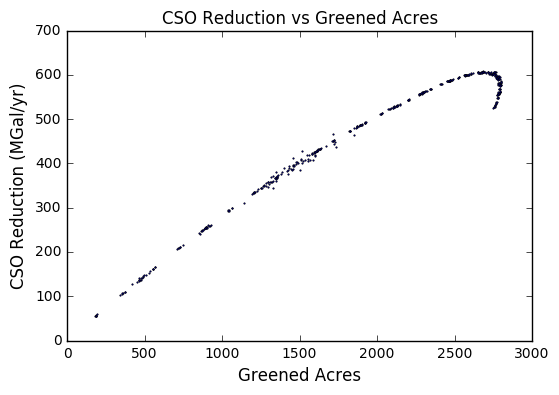

In [29]:
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction vs Greened Acres")
ax1.plot(greenedAcres,csoReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal/yr)",fontsize=12)

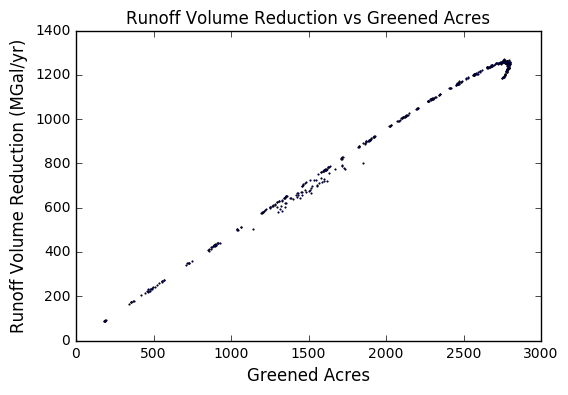

In [30]:
(fig, ax1) = plt.subplots()
plt.title("Runoff Volume Reduction vs Greened Acres")
ax1.plot(greenedAcres,volReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("Runoff Volume Reduction (MGal/yr)",fontsize=12)

Total number of SWMM runs = 430


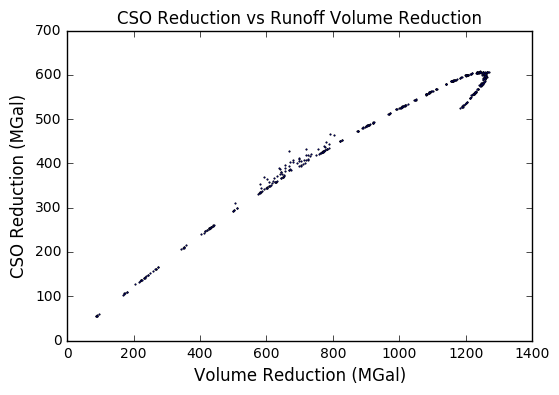

In [31]:
# SCATTER PLOT OF CSO ANNUAL VOLUME REDUCTION VS SEWER OUTFLOW ANNUAL VOLUME REDUCTION
%matplotlib inline
import matplotlib.pyplot as plt
print "Total number of SWMM runs = %d" % len(volReductionMgal)
#xRange = [50,70]
#yRange = [25,45]
(fig, ax1) = plt.subplots()
ax1.plot(volReductionMgal,csoReductionMgal,'ko',color = 'b',markersize = 1)
plt.title("CSO Reduction vs Runoff Volume Reduction")
ax1.set_xlabel("Volume Reduction (MGal)",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal)",fontsize=12)
#plt.xlim(xRange)
#plt.ylim(yRange)

In [32]:
#Single Variable Regression for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

limitedGreenedAcres = []
limitedCsoReduction = []
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= 2000.0:
        limitedGreenedAcres.append(greenedAcres[run])
        limitedCsoReduction.append(csoReduction[run])

csoReductionVsTotalGreenedAcresStats = reg_m(limitedCsoReduction,[limitedGreenedAcres])
print "Exact r-squared:"
print csoReductionVsTotalGreenedAcresStats.rsquared
print csoReductionVsTotalGreenedAcresStats.summary()
print csoReductionVsTotalGreenedAcresStats.params

Exact r-squared:
0.995373347206
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.174e+04
Date:                Fri, 13 Jan 2017   Prob (F-statistic):          1.95e-228
Time:                        09:16:40   Log-Likelihood:                -3400.2
No. Observations:                 196   AIC:                             6804.
Df Residuals:                     194   BIC:                             6811.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            2.5e+0

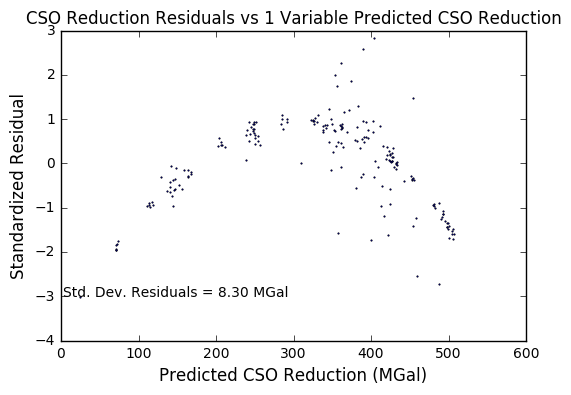

In [33]:
# Generate Residuals Plot for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#print limitedGreenedAcres
#xVals = limitedGreenedAcres
betaZero = csoReductionVsTotalGreenedAcresStats.params[1]
betaOne = csoReductionVsTotalGreenedAcresStats.params[0]
yPredicted = []
residuals = []
for i in range(0,len(limitedGreenedAcres)):
    yVal = betaZero + betaOne*limitedGreenedAcres[i]
    resid = limitedCsoReduction[i] - yVal
    yPredicted.append(yVal)  # Gallons
    residuals.append(resid)  # Gallons
#print yPredicted
yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
stdDevResidualsMGal = stdDevResiduals/1e6
standardizedResiduals = [x / stdDevResiduals for x in residuals]
#print standardizedResiduals
#print yPredictedMGal
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs 1 Variable Predicted CSO Reduction")
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMGal
ax1.text(2,-3,stdDevText)

In [34]:
#THREE Variable Regression for LIMITED GA CSO reductions for each run vs greened acres BY LID for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

limitedLidOneGreenedAcres = []
limitedLidTwoGreenedAcres = []
limitedLidThreeGreenedAcres = []
limitedCsoReduction = []
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= 2000.0:
        #limitedGreenedAcres.append(greenedAcres[run])
        limitedCsoReduction.append(csoReduction[run])
        limitedLidOneGreenedAcres.append(lidGreenedAcres[0][run])
        limitedLidTwoGreenedAcres.append(lidGreenedAcres[1][run])
        limitedLidThreeGreenedAcres.append(lidGreenedAcres[2][run])
#print limitedLidOneGreenedAcres
limitedLidGreenedAcres = [limitedLidOneGreenedAcres,limitedLidTwoGreenedAcres,limitedLidThreeGreenedAcres]

csoReductionVsLIDGreenedAcresStats = reg_m(limitedCsoReduction,limitedLidGreenedAcres)
print "Exact r-squared:"
print csoReductionVsLIDGreenedAcresStats.rsquared
print csoReductionVsLIDGreenedAcresStats.summary()
print csoReductionVsLIDGreenedAcresStats.params


Exact r-squared:
0.995810524326
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.521e+04
Date:                Fri, 13 Jan 2017   Prob (F-statistic):          5.91e-228
Time:                        09:16:57   Log-Likelihood:                -3390.5
No. Observations:                 196   AIC:                             6789.
Df Residuals:                     192   BIC:                             6802.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          2.563e+0

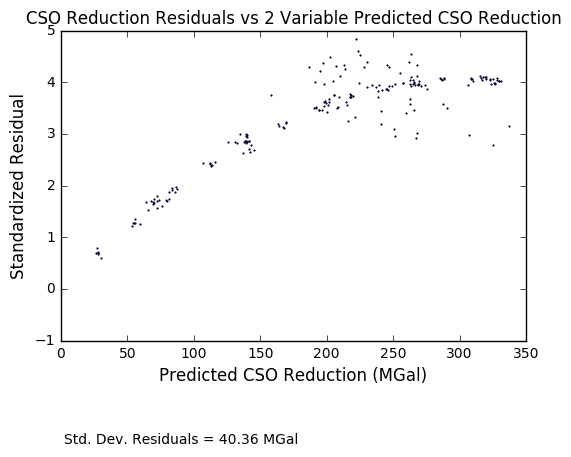

In [35]:
# Generate Residuals Plot for LIMITED GA CSO reductions for each run vs greened acres BY LID for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#print limitedGreenedAcres
#xVals = limitedGreenedAcres
betaZero = csoReductionVsLIDGreenedAcresStats.params[2]
betaOne = csoReductionVsLIDGreenedAcresStats.params[0]
betaTwo = csoReductionVsLIDGreenedAcresStats.params[1]
yPredicted = []
residuals = []
for i in range(0,len(limitedCsoReduction)):
    yVal = betaZero + betaOne*limitedLidOneGreenedAcres[i] + betaTwo*limitedLidTwoGreenedAcres[i]
    resid = limitedCsoReduction[i] - yVal
    yPredicted.append(yVal)  # Gallons
    residuals.append(resid)  # Gallons
#print yPredicted
yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
stdDevResidualsMGal = stdDevResiduals/1e6
standardizedResiduals = [x / stdDevResiduals for x in residuals]
#print standardizedResiduals
#print yPredictedMGal
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs 2 Variable Predicted CSO Reduction")
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMGal
ax1.text(2,-3,stdDevText)

In [36]:
# Multivariable Regression for LIMITED GA runs for Annual CSO Volumes vs FILTERED subcatchments
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range
import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

numberOfSubcatchmentsFiltered = 11
gaPerLid = [0.1,0.936,0.747]
greenedAcresFilteredTranspose = []
csoReductionFiltered = []
runoffVolumeReductionFiltered = []   # for runoff volume regression in later block
#chunks = [data[x:x+100] for x in xrange(0, len(data), 100)]
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= 2000.0:
        csoReductionFiltered.append(csoReduction[run])
        runoffVolumeReductionFiltered.append(volReduction[run])
        lidList = lidTransposed[run]
        lidChunks = [lidList[x:x+numSubcatch] for x in range(0,len(lidList),numSubcatch)]
        #print len(lidChunks[0])
        filteredSubcatsVariables = []
        for lid in range(0,numLID):
            filteredSubcats = lidChunks[lid][0:numberOfSubcatchmentsFiltered]
            filteredSubcatsGreenedAcres = [gaPerLid[lid]*filteredSubcats[i] for i in range(0,len(filteredSubcats))]
            #print sevenSubcatsGreenedAcres
            filteredSubcatsVariables += filteredSubcatsGreenedAcres
        greenedAcresFilteredTranspose.append(filteredSubcatsVariables)
        #print sevenSubcatsVariables
        #[list(i) for i in zip(*theArray)]
greenedAcresFiltered = [list(i) for i in zip(*greenedAcresFilteredTranspose)]
#print greenedAcres
#print csoReductionFiltered

csoReductionStats = reg_m(csoReductionFiltered,greenedAcresFiltered)
print "Exact r-squared:"
print csoReductionStats.rsquared
print csoReductionStats.summary()
print csoReductionStats.params
#print reducedLIDNumbers
#print reducedGreenedAcres
      

Exact r-squared:
0.984573482578
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     313.3
Date:                Fri, 13 Jan 2017   Prob (F-statistic):          4.54e-130
Time:                        09:18:13   Log-Likelihood:                -3518.2
No. Observations:                 196   AIC:                             7104.
Df Residuals:                     162   BIC:                             7216.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           1.69e+0

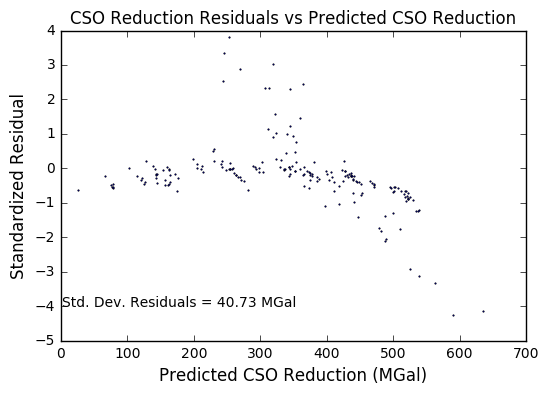

In [37]:
# Generate Residuals Plot for for LIMITED GA runs for Annual CSO Volumes vs FILTERED subcatchments
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# First, transpose results['numLists']:
xVals = greenedAcresFilteredTranspose
#print list(xVals[1])
numFilteredVariables = len(greenedAcresFiltered)
betaZero = csoReductionStats.params[numFilteredVariables]
yPredicted = []
for x in xVals:
    i = 0
    yval = betaZero
    for beta in csoReductionStats.params:
        yval += beta*x[i]
        i += 1
        if i == numFilteredVariables:
            break
    yPredicted.append(yval/1e6)  # convert to 10^6 Gal
residuals = []
csoReductionFilteredMgal = [x / 1e6 for x in csoReductionFiltered]
i = 0
for ySWMM in csoReductionFilteredMgal:
    #print ySWMM
    resid = ySWMM - yPredicted[i]  # Residual in 10^6 Gal
    residuals.append(resid)
    i+=1
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs Predicted CSO Reduction")
ax1.plot(yPredicted,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResiduals
ax1.text(2,-4,stdDevText)


In [38]:
# Multivariable Regression for Annual Runoff VOLUME Reductions vs Filtered PWD Wingohocking subcatchments
import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

print len(greenedAcresFiltered)
print len(greenedAcresFiltered[0])
#print runoffVolumeReductionFiltered

runoffReductionStats = reg_m(runoffVolumeReductionFiltered,greenedAcresFiltered)
print "Exact r-squared:"
print runoffReductionStats.rsquared
print runoffReductionStats.summary()
print runoffReductionStats.params


33
196
Exact r-squared:
0.987530643395
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     388.8
Date:                Fri, 13 Jan 2017   Prob (F-statistic):          1.55e-137
Time:                        09:18:39   Log-Likelihood:                -3620.7
No. Observations:                 196   AIC:                             7309.
Df Residuals:                     162   BIC:                             7421.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          2

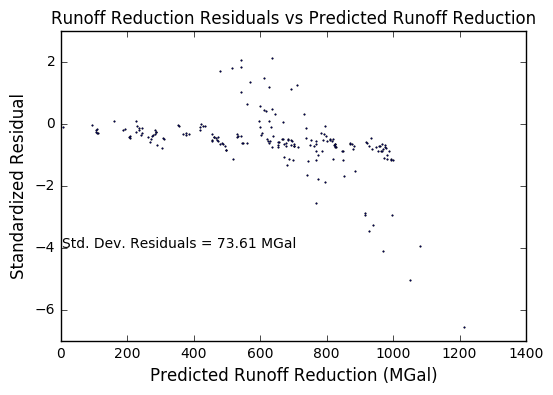

In [39]:
# Generate Residuals Plot for FILTERED Annual RUNOFF Volumes vs reduced number of subcatchments
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# First, transpose results['numLists']:
xVals = greenedAcresFilteredTranspose
#print list(xVals[1])
numFilteredVariables = len(greenedAcresFiltered)
betaZero = runoffReductionStats.params[numFilteredVariables]
yPredicted = []
for x in xVals:
    i = 0
    yval = betaZero
    for beta in runoffReductionStats.params:
        yval += beta*x[i]
        i += 1
        if i == numFilteredVariables:
            break
    yPredicted.append(yval/1e6)  # convert to 10^6 Gal
residuals = []
runoffVolumeReductionFilteredMgal = [x / 1e6 for x in runoffVolumeReductionFiltered]
i = 0
for ySWMM in runoffVolumeReductionFilteredMgal:
    #print ySWMM
    resid = ySWMM - yPredicted[i]  # Residual in 10^6 Gal
    residuals.append(resid)
    i+=1
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]
(fig, ax1) = plt.subplots()
ax1.plot(yPredicted,standardizedResiduals,'ko',color = 'b',markersize = 1)
plt.title("Runoff Reduction Residuals vs Predicted Runoff Reduction")
ax1.set_xlabel("Predicted Runoff Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResiduals
ax1.text(2,-4,stdDevText)

In [42]:
# Multivariable regression for statmodel cso reduction parameters versus subcatchment properties
import yaml
from swmm_objects import *
from swmm_read_cso_time_series import *

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

swmmInpFile = "wingohocking_PWD.inp"  # initial SWMM .inp file
lidListFile = "PWD_wingo_RainBarrel_MorrisIT_WakefieldRG_LID_List.yaml"
infile = open(swmmInpFile,'r')
swmmInpStr = infile.readlines()
infile.close()
(section_names,sections) = read_inp(swmmInpStr)
model = swmm_model("Model",section_names,sections)
f = open(lidListFile,'r')   # Read the LID parameters used to calculate [LID_USAGE]
lidUsageList = yaml.load(f)  # list of dicts, one for each line in [LID_USAGE]
f.close()
lidUsageChunks = [lidUsageList[x:x+numSubcatch] for x in range(0,len(lidUsageList),numSubcatch)]
#print lidUsageChunks[1]

# These lists will hold LID and subcatchment parameters for the filtered subcatchments only
lidGreenedAcres = []
lidContribImpervArea = []
subcatArea = []
subcatPctImperv = []
subcatImpervArea = []
subcatWidth = []
subcatSlope = []

for lid in range(0,numLID):
    listItem = 1
    for lidUsage in lidUsageChunks[lid]:
        if listItem <= numberOfSubcatchmentsFiltered:   # limit the lists to filtered subcatchments
            subcatName = lidUsage['Subcat']
            lidGreenedAcres.append(lidUsage['GreenedAcres'])
            lidContribImpervArea.append(lidUsage['ContribImpervArea'])
            thisSubcatArea = model.getSubcatchmentArea(subcatName)
            subcatArea.append(thisSubcatArea)
            thisSubcatPctImperv = model.getSubcatchmentPctImperv(subcatName)
            subcatPctImperv.append(thisSubcatPctImperv)
            thisSubcatImpervArea = (thisSubcatPctImperv/100.0)*thisSubcatArea
            subcatImpervArea.append(thisSubcatImpervArea)
            subcatWidth.append(model.getSubcatchmentWidth(subcatName))
            subcatSlope.append(model.getSubcatchmentSlope(subcatName))
            listItem += 1
        else:
            break   # ignore subcatchments indexed above the filtered group

#paramIndVars = [lidGreenedAcres,lidContribImpervArea,subcatArea]  # choose which independent vars to use
#paramIndVars = [subcatArea,subcatPctImperv,subcatWidth,subcatSlope]
#paramIndVars = [subcatArea]
paramIndVars = [subcatPctImperv]
#paramIndVars = [lidGreenedAcres,]
#paramIndVars = [lidContribImpervArea,subcatArea]
#paramIndVars = [subcatImpervArea]
#paramIndVars = [subcatSlope]
numberOfParamIndVars = len(paramIndVars)
numberOfParamDependentVarValues = len(csoReductionStats.params)-1  # only lid/subcat slopes without the intercept
paramDepVarValues = csoReductionStats.params[0:numberOfParamDependentVarValues]
#print numberOfParamDependentVarValues
#print len(paramIndVars)
#print len(paramIndVars[0])
#print len(paramDepVarValues)

paramStats = reg_m(paramDepVarValues,paramIndVars)
print "Exact r-squared:"
print paramStats.rsquared
print paramStats.summary()
print paramStats.params


Exact r-squared:
0.147264385405
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5.354
Date:                Fri, 13 Jan 2017   Prob (F-statistic):             0.0275
Time:                        09:22:07   Log-Likelihood:                -483.90
No. Observations:                  33   AIC:                             971.8
Df Residuals:                      31   BIC:                             974.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -3.496e+0

[1.6896610291398273, 0.64451198342230287, 0.41239657763458903, 0.85315879682456985, 0.43709849928608185, 0.73519664572304133, 0.73861045134640557, 1.1755212472202872, 0.25418307153109321, 0.27756087069532553, 1.3932067863776434, 1.0384210361428134, 0.23378193763038632, 0.092468779182537458, 0.36600778247807592, 1.042570890991833, 1.1499093909415752, 0.071568412702013737, 0.094098935658606928, 0.60718306391083798, 0.44707775163173064, 1.4353286058699219, 1.4564641637738489, 0.35876028010611355, 0.89026341310469792, 0.45152017851025422, 2.6198054278817202, -0.82055638225540428, 0.66398616167524871, 0.63939482026921124, 0.22270682380641857, 0.30060184676716462, 1.3531373503132258]
[0.98521248940748418, 0.66578627888192232, 0.43251004457516362, 0.71784687733557406, 0.89871287854493598, 0.76829915642799806, 0.99965240019415857, 0.83035930569276073, 0.50883528730472827, 0.19094746921164496, 0.77704002252162663, 0.98521248940748418, 0.66578627888192232, 0.43251004457516362, 0.7178468773355740

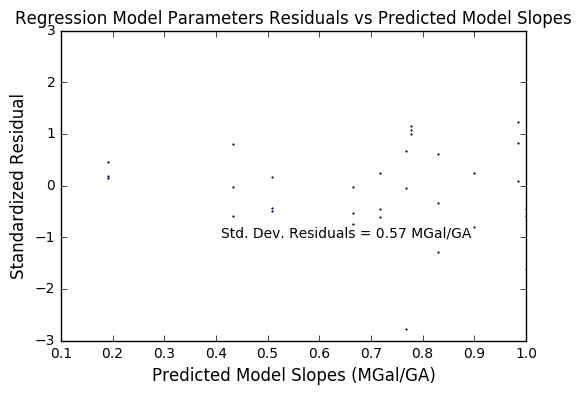

In [43]:
# Generate Residuals Plot for Regression Parameters vs LID and Subcatchment Properties
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# First, transpose results['numLists']:
xVals = list(zip(*paramIndVars))
#print xVals
#print list(xVals[0])
indexOfBetaZero = len(paramStats.params)-1
#print indexOfBetaZero
betaZero = paramStats.params[indexOfBetaZero]
#print betaZero
yPredicted = []

for x in xVals:
    i=0
    yval = betaZero
    for beta in paramStats.params:
        yval += beta*x[i]
        i+=1
        if i == indexOfBetaZero:
            break
    yPredicted.append(yval)  


paramDepVarValuesMGal = [x/1e6 for x in paramDepVarValues]
yPredictedMGal = [x/1e6 for x in yPredicted]
print paramDepVarValuesMGal
print yPredictedMGal

residuals = []

i = 0
for yActual in paramDepVarValues:
    resid = yActual - yPredicted[i]  # Residual in 10^6 Gal
    residuals.append(resid)
    i+=1
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]
(fig, ax1) = plt.subplots()
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
plt.title("Regression Model Parameters Residuals vs Predicted Model Slopes")
ax1.set_xlabel("Predicted Model Slopes (MGal/GA)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal/GA" % (stdDevResiduals/1e6)  # convert to MGal
ax1.text(0.41,-1,stdDevText)
